# How does degree of functionality affect LAS correlations?

In [Measuring degree of functionality](/notebooks/8.%20Measuring%20degree%20of%20functionality.ipynb#), we found out that you can use the Inverse Word Entropy (IWE) to calculate the degree of functionality (DoF) of a deprel. In [How much does functional dependents contribute to the overall LAS?](/notebooks/7.%20How%20much%20does%20functional%20dependents%20contribute%20to%20the%20overall%20LAS%3F.ipynb) we found out that if you only look at functional dependency relations and their frequency ratio, LAS/ratio plotting has a pretty nice correlation.

What I'm hoping to see here is that if we cumulatively add dependency relations in order according to their degree of functionality, at first the correlation might fluctuate a bit, but we will see a max corr value just at the limit of functional vs content dependencies.

__Potential caveat__: Degree of functionality is calculated on the training data while LAS is calculated on the dev sets. I don't think this matters.

## Summary

We get a maximum close to the border between functional and content dependencies, which is quite nice!

In [1]:
# Matplotlib
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

# Remove warnings
import warnings
#warnings.filterwarnings('ignore')

import sys, os
from os.path import join
sys.path.append("../tools/")
from collections import defaultdict

# Data management libraries
import pandas as pd
import seaborn as sns

# Treebank utils, found in "../tools"
import udeval, udtree, lang_utils, dependency_classes

is_labeled = True
is_fine_grained_deprels = False
file_format = "conllx"
test_type = "test"

system_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/maltdefault_coarse_output_test_1-2/"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-2/universal-dependencies-1.2/"
file_prefix = "maltdefault"

system_files = lang_utils.get_system_output_paths(system_output_base, type_=test_type, format_=file_format)
gold_files = lang_utils.get_ud_paths(gold_output_base, type_=test_type, format_=file_format, coarse=True)

from collections import defaultdict

def label_ratio(trees, label_class):
    deprel_freqs = 0
    total_deprels = 0
    for tree in trees:
        for deprel in tree.deprels:
            if not is_fine_grained_deprels:
                label = deprel.split(":")[0]
            total_deprels += 1
            if label in label_class:
                deprel_freqs += 1
    deprel_dist = deprel_freqs / total_deprels
    return deprel_dist

def language_deprel_ratio(treebank_paths, label_class):
    lang_deprels = {}
    for lang, path in treebank_paths.items():
        lang_deprels[lang] = label_ratio(udtree.from_files(path), label_class)
    return lang_deprels

def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang]
        precision, recall = udeval.labels_precision_recall(s_out, 
                                                           g_out, 
                                                           labels=labels,
                                                           fine_grained_deprels=is_labeled)
        index.append(lang)
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

dof = pd.Series.from_csv('../data/degree_of_functionality.inverse_word_entropy.csv')

/Users/jimmy/dev/miniconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Cumulatively add functional deprels

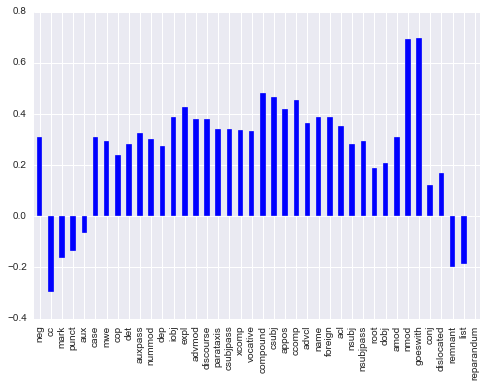

In [2]:
labels = []
results = []
for deprel in dof.index:
    labels.append(deprel)
    results.append(precision_recall_filter_labels(labels))
    
ratio_labels = []
ratio_results = []
for deprel in dof.index:
    ratio_labels.append(deprel)
    ratio_results.append(pd.Series(language_deprel_ratio(gold_files, ratio_labels)).fillna(0))
    
corrs = []
for label, las_result, ratio_result in zip(labels, results, ratio_results):
    df = pd.concat([las_result['recall'], ratio_result], axis=1)
    df.columns = [label + ' recall', label + ' ratio']
    corrs.append(df.corr().ix[1,0])

corrs = pd.Series(corrs, index=labels)
corrs.to_csv('../data/maltdefault.dof_las_corr.cumulative.csv')
corrs.plot(kind='bar')



## Correlation for individual labels

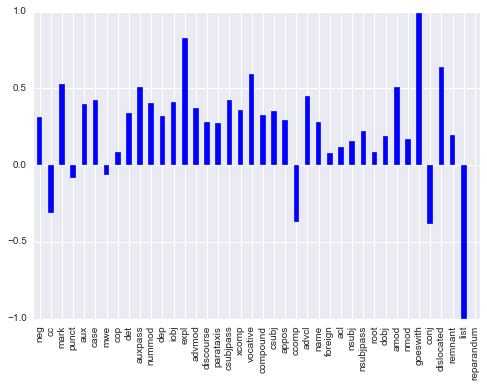

In [3]:
labels = []
results = []
for deprel in dof.index:
    labels.append(deprel)
    results.append(precision_recall_filter_labels(deprel))
    
ratio_results = []
for deprel in dof.index:
    ratio_results.append(pd.Series(language_deprel_ratio(gold_files, deprel)).fillna(0))
    
corrs = []
for label, las_result, ratio_result in zip(labels, results, ratio_results):
    df = pd.concat([las_result['recall'], ratio_result], axis=1)
    df.columns = [label + ' recall', label + ' ratio']
    corrs.append(df.corr().ix[1,0])

corrs = pd.Series(corrs, index=labels)
corrs.to_csv('../data/maltdefault.dof_las_corr.individual.csv')
corrs.plot(kind='bar')

Indeed, individual label correlation seems to be pretty random.

## Cumulatively adding dependencies in opposite order

If our hypothesis holds, as we add dependencies in the opposite order starting with the least degree of functionality, the correlation should be more or less random.

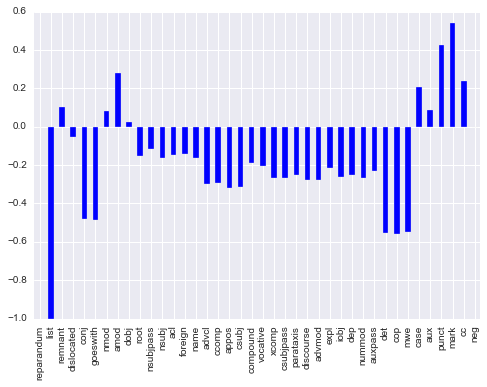

In [4]:
labels = []
results = []
for deprel in dof.index[::-1]:
    labels.append(deprel)
    results.append(precision_recall_filter_labels(labels))
    
ratio_labels = []
ratio_results = []
for deprel in dof.index[::-1]:
    ratio_labels.append(deprel)
    ratio_results.append(pd.Series(language_deprel_ratio(gold_files, ratio_labels)).fillna(0))
    
corrs = []
for label, las_result, ratio_result in zip(labels, results, ratio_results):
    df = pd.concat([las_result['recall'], ratio_result], axis=1)
    df.columns = [label + ' recall', label + ' ratio']
    corrs.append(df.corr().ix[1,0])

corrs = pd.Series(corrs, index=labels)
corrs.plot(kind='bar')

I'm not sure what actually happens here. There is a weird shift happening at _case_. I don't think this is anything to really care about.

## What if we remove punct?

It's really the odd one out from the list.

About the same results. Some more fluctuation in the beginning.

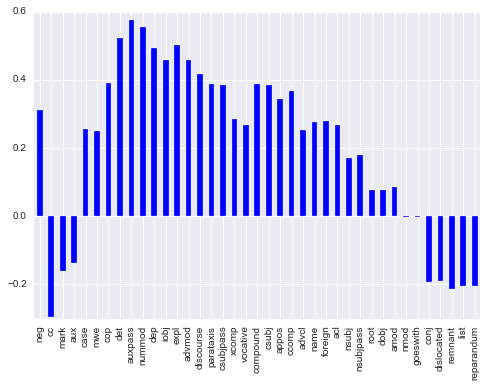

In [5]:
labels = []
results = []
dof_order = list(dof.index)
dof_order.remove('punct')

for deprel in dof_order:
    labels.append(deprel)
    results.append(precision_recall_filter_labels(labels))
    
ratio_labels = []
ratio_results = []
for deprel in dof_order:
    ratio_labels.append(deprel)
    ratio_results.append(pd.Series(language_deprel_ratio(gold_files, ratio_labels)).fillna(0))
    
corrs = []
for label, las_result, ratio_result in zip(labels, results, ratio_results):
    df = pd.concat([las_result['recall'], ratio_result], axis=1)
    df.columns = [label + ' recall', label + ' ratio']
    corrs.append(df.corr().ix[1,0])

corrs = pd.Series(corrs, index=labels)
corrs.plot(kind='bar')

# sTTR

In [21]:
sttr = pd.DataFrame.from_csv('../data/standard_ttr.1.2.csv')['mean'].sort_values(ascending=False)
dof = pd.Series.from_csv('../data/degree_of_functionality.inverse_word_entropy.csv').sort_values(ascending=False)
fratio = pd.Series(language_deprel_ratio(gold_files, dependency_classes.function_dependents)).sort_values(ascending=False)

In [27]:
labels = []
ratios = []
for label, val in dof.iteritems():
    if label == 'punct':
        continue
    labels.append(label)
    ratios.append(language_deprel_ratio(gold_files, labels))

ratios    

[{'Arabic': 0.004138955709636338,
  'Basque': 0.010995322885041438,
  'Bulgarian': 0.00883437142493962,
  'Croatian': 0.002909090909090909,
  'Czech': 0.00020699172033118675,
  'Danish': 0.009857239972807614,
  'Dutch': 0.0034019695613249777,
  'English': 0.010041440867070449,
  'Finnish': 0.00973741794310722,
  'Gothic': 0.01996898022489337,
  'Greek': 0.0072335920959774175,
  'Hebrew': 0.005608247422680413,
  'Hindi': 0.005193338978267005,
  'Italian': 0.008035062089116142,
  'Norwegian': 0.009988679496570554,
  'Old_Church_Slavonic': 0.019492025989367986,
  'Persian': 0.00018724254150543002,
  'Polish': 0.015309672929714684,
  'Portuguese': 0.006136014999147775,
  'Slovenian': 0.00426651496835668,
  'Spanish': 0.010310574625927323,
  'Swedish': 0.009029788487019678},
 {'Arabic': 0.07496108674119145,
  'Basque': 0.04915073438910314,
  'Bulgarian': 0.03851531714757849,
  'Croatian': 0.03903030303030303,
  'Czech': 0.03920193192272309,
  'Danish': 0.03653976886471788,
  'Dutch': 0.0463

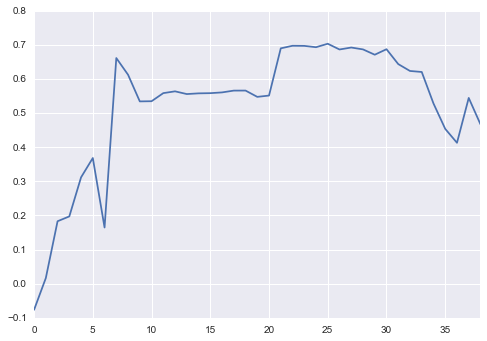

In [28]:
corrs = []
for ratio in ratios:
    corrs.append(pd.concat([sttr, pd.Series(ratio)], axis=1).corr().ix[0,1])
pd.Series(corrs).plot()

In [37]:
labels

['neg',
 'cc',
 'mark',
 'mwe',
 'auxpass',
 'cop',
 'aux',
 'case',
 'expl',
 'det',
 'csubjpass',
 'discourse',
 'vocative',
 'dep',
 'foreign',
 'goeswith',
 'dislocated',
 'nummod',
 'reparandum',
 'iobj',
 'parataxis',
 'compound',
 'list',
 'remnant',
 'csubj',
 'nsubjpass',
 'advmod',
 'name',
 'xcomp',
 'appos',
 'ccomp',
 'advcl',
 'acl',
 'nsubj',
 'root',
 'dobj',
 'amod',
 'nmod',
 'conj']